<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Hyperparameter Tuning

## *Data Science Unit 4 Sprint 2 Assignment 4*

## Your Mission, should you choose to accept it...

To hyperparameter tune and extract every ounce of accuracy out of this telecom customer churn dataset: <https://drive.google.com/file/d/1dfbAsM9DwA7tYhInyflIpZnYs7VT-0AQ/view> 

## Requirements

- Load the data
- Clean the data if necessary (it will be)
- Create and fit a baseline Keras MLP model to the data.
- Hyperparameter tune (at least) the following parameters:
 - batch_size
 - training epochs
 - optimizer
 - learning rate (if applicable to optimizer)
 - momentum (if applicable to optimizer)
 - activation functions
 - network weight initialization
 - dropout regularization
 - number of neurons in the hidden layer
 
 You must use Grid Search and Cross Validation for your initial pass of the above hyperparameters
 
 Try and get the maximum accuracy possible out of this data! You'll save big telecoms millions! Doesn't that sound great?


In [1]:
# imports

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import Normalizer
import tensorflow as tf
from tensorflow import keras

In [3]:
pwd

'/Users/claudiachajon/Documents/lambda/LAMBDA_DS9/DS-Unit-4-Sprint-2-Neural-Networks/DS-Unit-4-Sprint-2-Neural-Networks/module4-Hyperparameter-Tuning'

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/claudiasofiaC/DS-Unit-4-Sprint-2-Neural-Networks/master/module4-Hyperparameter-Tuning/WA_Fn-UseC_-Telco-Customer-Churn%2B(1).csv')


In [5]:
df.head()

# gotta clean this bad boi up

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [11]:
df.shape

(7043, 21)

In [9]:
df.columns.tolist()

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [19]:
features = ['gender',
            'SeniorCitizen',
            'Partner',
            'Dependents',
            'tenure',
            'PhoneService',
            'MultipleLines',
            'InternetService',
            'OnlineSecurity',
            'OnlineBackup',
            'DeviceProtection',
            'TechSupport',
            'StreamingTV',
            'StreamingMovies',
            'Contract',
            'PaperlessBilling',
            'PaymentMethod',
            'MonthlyCharges',
            'TotalCharges']

target = 'Churn'

In [20]:
df.describe(include='all') # neat

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,...,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2,NaN,2,3,3,3,...,3,3,3,3,3,2,4,NaN,6531,2
top,9170-ARBTB,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,,No
freq,1,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,...,3095,3473,2810,2785,3875,4171,2365,NaN,11,5174
mean,NaN,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN


In [14]:
# a cleansing rain to clear the trash off of the streets
# oof

for feature in features:
    
    print(df[feature].value_counts(dropna=False))

Male      3555
Female    3488
Name: gender, dtype: int64
0    5901
1    1142
Name: SeniorCitizen, dtype: int64
No     3641
Yes    3402
Name: Partner, dtype: int64
No     4933
Yes    2110
Name: Dependents, dtype: int64
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: tenure, Length: 73, dtype: int64
Yes    6361
No      682
Name: PhoneService, dtype: int64
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64
No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64
No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64
No            

In [15]:
# to Churn or not to Churn

df['Churn'].value_counts(normalize=True)


No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

In [16]:
class_weight = {0: 1,
               1: 3}

In [21]:
# ok here we go, scrub it down

df['gender'] = df['gender'].replace({'Female': 0, 'Male': 1})

In [46]:
df['Contract'] = df['Contract'].replace({'Month-to-month': 0,
                                        "One year": 1,
                                        'Two year': 2})

In [24]:
df['InternetService'] = df['InternetService'].replace({'No': -1,
                                                     'DSL': 0,
                                                     'Fiber optic': 1})

In [27]:
df = df.replace({'No': 0,
                'Yes': 1,
                'No phone service': -1,
                'No internet service': -1})

In [30]:
df['AutoPay'] = df['PaymentMethod'].str.contains('automatic').astype(int)

In [31]:
df['EPay'] = (df['PaymentMethod'] != 'Mailed check').astype(int)

In [33]:
df['DebitPay'] = (df["PaymentMethod"] != 'Credit card (automatic)').astype(int)

In [34]:
df['TotalCharges'] = df['TotalCharges'].str.strip()

In [35]:
df['TotalCharges'] = df['TotalCharges'].replace('', 0)

In [36]:
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [47]:

features = ['gender',
            'SeniorCitizen',
            'Partner',
            'Dependents',
            'tenure',
            'PhoneService',
            'MultipleLines',
            'InternetService',
            'OnlineSecurity',
            'OnlineBackup',
            'DeviceProtection',
            'TechSupport',
            'StreamingTV',
            'StreamingMovies',
            'Contract',
            'PaperlessBilling',
            'AutomaticPayment',
            'EPay',
            'DebitPay',
            'MonthlyCharges',
            'TotalCharges']

In [41]:
df[features].head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,AutomaticPayment,EPay,DebitPay,MonthlyCharges,TotalCharges
0,0,0,1,0,1,0,-1,0,0,1,...,0,0,0,Month-to-month,1,0,1,1,29.85,29.85
1,1,0,0,0,34,1,0,0,1,0,...,0,0,0,1,0,0,0,1,56.95,1889.50
2,1,0,0,0,2,1,0,0,1,1,...,0,0,0,Month-to-month,1,0,0,1,53.85,108.15
3,1,0,0,0,45,0,-1,0,1,0,...,1,0,0,1,0,1,1,1,42.30,1840.75
4,0,0,0,0,2,1,0,1,0,0,...,0,0,0,Month-to-month,1,0,1,1,70.70,151.65


In [48]:
X = df[features].values

In [49]:
y = df[target].values

In [50]:
normalizer = Normalizer()

In [51]:
X = normalizer.fit_transform(X)

In [ ]:
# oooooof

In [52]:
# create and fit a baseline keras mlp model

baseline_model = keras.Sequential()

In [53]:
baseline_model.add(keras.layers.Dense(1, input_dim=len(features), activation='relu'))
baseline_model.add(keras.layers.Dense(1, activation='sigmoid'))


In [54]:
baseline_model.compile(loss='binary_crossentropy', metrics=['acc'], optimizer='adam')


In [55]:
# history
# lecture style

baseline_history = baseline_model.fit(X, y, epochs=50, validation_split=0.2,
                                     class_weight=class_weight, verbose=False)

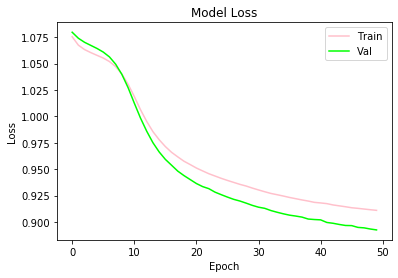

In [56]:
# plot train and val loss

plt.plot(baseline_history.history['loss'], color='pink')
plt.plot(baseline_history.history['val_loss'], color='lime')

plt.title('Model Loss')

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Train', 'Val'], loc='best')

plt.show()

In [ ]:
# omg what now???

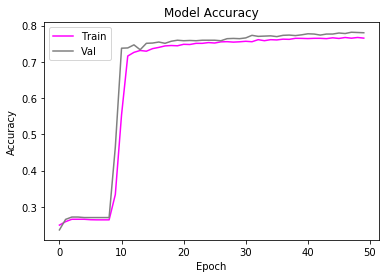

In [58]:
# plot train and val accuracy values

plt.plot(baseline_history.history['acc'], color='fuchsia')
plt.plot(baseline_history.history['val_acc'], color='grey')

plt.title('Model Accuracy')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Val'], loc='best')

plt.show()

In [ ]:
# the hell???

## Stretch Goals:

- Try to implement Random Search Hyperparameter Tuning on this dataset
- Try to implement Bayesian Optimiation tuning on this dataset using hyperas or hyperopt (if you're brave)
- Practice hyperparameter tuning other datasets that we have looked at. How high can you get MNIST? Above 99%?
- Study for the Sprint Challenge
 - Can you implement both perceptron and MLP models from scratch with forward and backpropagation?
 - Can you implement both perceptron and MLP models in keras and tune their hyperparameters with cross validation?